In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

cv_data = pd.read_csv("/content/drive/MyDrive/6.871/group project/cv_data.csv")
labels_df = pd.read_csv("/content/drive/MyDrive/6.871/group project/df_unique.csv")

In [ ]:
# data splitting
import random
feat_names_lab = list(cv_data)
def stratify_idx(df, pats, split = (0.8, 0.1, 0.1), load = False, save = False):
    if load:
        train_indices = np.load("train_indices.npy")
        val_indices = np.load("val_indices.npy")
        test_indices = np.load("test_indices.npy")

    if not load:

        pt_ids, pt_lengths = np.unique(df["pt_id"], return_counts=True)
        # Set random seed for replicable result
        random.seed(42)
        # 0 for training, 1 for validation, 2 for testing
        assignment = np.array(random.choices(population=[0, 1, 2], weights=split, k=len(pt_ids)))
        pt_train = pats[np.nonzero(assignment == 0)[0]]
        pt_val = pats[np.nonzero(assignment == 1)[0]]
        pt_test = pats[np.nonzero(assignment == 2)[0]]


        train_indices = df.query('pt_id in @pt_train').index
        val_indices = df.query('pt_id in @pt_val').index
        test_indices = df.query('pt_id in @pt_test').index

    if save:
        np.save("pt_train", pt_train)
        np.save("pt_val", pt_val)
        np.save("pt_test", pt_test)

        np.save("train_indices", train_indices)
        np.save("val_indices", val_indices)
        np.save("test_indices", test_indices)

    return train_indices, val_indices, test_indices
  
indices = stratify_idx(labels_df, pats = labels_df['pt_id'].unique(), split = (0.8, 0.1, 0.1), load = False, save = False)

#split into train, val and test
train_X = labels_df.iloc[indices[0]][feat_names_lab].values
val_X = labels_df.iloc[indices[1]][feat_names_lab].values
test_X = labels_df.iloc[indices[2]][feat_names_lab].values

train_y = labels_df.iloc[indices[0]]["bin_symptoms"].values
val_y = labels_df.iloc[indices[1]]["bin_symptoms"].values
test_y = labels_df.iloc[indices[2]]["bin_symptoms"].values

In [ ]:
# write a loop going through all C and penalty values, select the values with best validation accuracy (see chunk below)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

d = {'C': [0.1,0.25,0.5,1., 0.1,0.25,0.5,1.], 'penalty': ['l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2']}
d = pd.DataFrame(data=d)
for i in d.index:
  pipe = Pipeline([('norm', StandardScaler()), ('LR', LogisticRegression(C=d["C"][i], penalty=d["penalty"][i], solver='liblinear'))])
  pipe.fit(train_X, train_y)
  ypred = pipe.predict(val_X)
  #accuracy
  d.loc[i, "validation_acc"] = accuracy_score(val_y, ypred)

max_validation_acc = d["validation_acc"].max()
C_best = d[d["validation_acc"] == max_validation_acc ][["C"]].squeeze()
penalty_best = d[d["validation_acc"] == max_validation_acc ][["penalty"]].squeeze()


In [ ]:
# getting predictions on test data
pipe = Pipeline([('norm', StandardScaler()), ('LR', LogisticRegression(C=C_best, penalty=penalty_best, solver='liblinear'))])
model_best = pipe.fit(train_X, train_y)
model_best.fit(train_X, train_y)
ypred2 = model_best.predict(test_X)


test accuracy: 0.877863827040981


In [ ]:
from sklearn import metrics
#Confusion matrix, Accuracy, sensitivity and specificity
# Creating the confusion matrix

#acc = accuracy_score(y_df_test, ypred2)
cm = metrics.confusion_matrix(test_y, ypred2)
# Assigning columns names
cm_df = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
# Showing the confusion matrix
cm_df

,Predicted Negative,Predicted Positive
Actual Negative,5049,120
Actual Positive,637,392


In [ ]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [ ]:
confusion_metrics(cm)

True Positives: 392
True Negatives: 5049
False Positives: 120
False Negatives: 637
--------------------------------------------------
Accuracy: 0.88
Mis-Classification: 0.12
Sensitivity: 0.38
Specificity: 0.98
Precision: 0.98
f_1 Score: 0.55


In [ ]:
roc_auc_score(test_y, ypred2)

0.6788685294198933

In [ ]:
# feature importance
#lr = pipe['LR']
#feature_importance = pd.DataFrame({
#    'features': feat_names_lab,
#    'coefs': lr.coef_[-1,:]
#})

#feature_importance.sort_values(by = 'coefs', ascending = False).head(30)

In [ ]:
np.save("y_pred_bowlr", ypred2)
np.save("y_true_bowlr", test_y)

In [ ]:
# getting the predicted probabilities
label_probs = pipe.predict_proba(test_X)
np.save("label_probs", label_probs)

In [ ]:
# feature importance
output = {'feature': feat_names_lab, 'coefficient': model_best.named_steps['LR'].coef_[0] }
output = pd.DataFrame(data=output)
output['abs_coeff'] = output['coefficient'].abs()
features_ranked = output.sort_values(by=['abs_coeff'], ascending=False).head(10)


In [ ]:
features_ranked

,feature,coefficient,abs_coeff
83,_generalpain_,0.831062,0.831062
245,consent,-0.388663,0.388663
96,_numbness,0.342983,0.342983
101,_swelling_,0.321771,0.321771
95,_nausea_,0.309570,0.309570
80,_fatigue_,0.298565,0.298565
89,_insomnia_,0.290818,0.290818
142,asking,-0.281849,0.281849
77,_diarrhea_,0.263931,0.263931
238,comment,-0.260747,0.260747


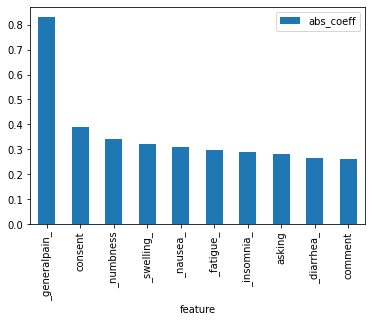

In [ ]:
features_ranked.plot.bar(x='feature', y='abs_coeff', rot=90, kind="barh")

In [ ]:
# getting the bootstrapped accuracy / AUC / precision / recall as in the table
#%pip install scipy==1.7.1
from scipy.stats import bootstrap
thresh = 0.5

In [ ]:
boot_prec = bootstrap((test_y,ypred2 > thresh), precision_score, vectorized = False, paired = True, random_state = 42, method = 'basic', n_resamples = 1000)
(boot_prec.confidence_interval.high + boot_prec.confidence_interval.low)/2

0.7680292151877217

In [ ]:
boot_prec.standard_error

0.018983568900135597

In [ ]:
boot_auc = bootstrap((test_y,ypred2 > thresh), roc_auc_score, vectorized = False, paired = True, random_state = 42, method = 'basic', n_resamples = 1000)
(boot_auc.confidence_interval.high + boot_auc.confidence_interval.low)/2

0.6788083549957036

In [ ]:
boot_auc.standard_error

0.008179812932163872

In [ ]:
boot_acc = bootstrap((test_y,ypred2 > thresh), accuracy_score, vectorized = False, paired = True, random_state = 42, method = 'basic', n_resamples = 1000)
(boot_acc.confidence_interval.high + boot_acc.confidence_interval.low)/2

0.8781058405937399

In [ ]:
boot_acc.standard_error

In [ ]:
boot_rec = bootstrap((test_y,ypred2 > thresh), recall_score, vectorized = False, paired = True, random_state = 42, method = 'basic', n_resamples = 1000)
(boot_rec.confidence_interval.high + boot_rec.confidence_interval.low)/2

0.38046777794789444

In [ ]:
boot_rec.standard_error

0.016259220930405764